# AI Journal special Issue XAI -  experiments

In [24]:
from pathlib import Path
import json
import sys
import math
import subprocess
from collections import Counter
import matplotlib.pyplot as plt
from statistics import mean
import pandas as pd
from IPython.display import display, HTML
from plotly import graph_objects as go, express as px
import numpy as np

In [85]:
holygrail_dir_path = '/home/crunchmonster/Documents/VUB/holygrail/'

In [25]:
def file_pprint_json(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    print(json.dumps(array, indent=4, sort_keys=True))
    
def read_print(filename):
    q = Path(filename)
    with q.open() as f: 
        s = f.readlines()
        #print(s)

def json2array(filename):
    with open(filename, 'r') as f:
        array = json.load(f)
    return array

def pprint_json(array):
    print(json.dumps(array, indent=4, sort_keys=False))

In [27]:
def basecost(clues, constraints):
    if constraints == 1 and clues == 0:
        return 0
    elif constraints > 1 and clues == 0:
        return 100
    else:
        return 100 * clues    

def basecost_old(clues, constraints, assumptions):
    if constraints == 1 and clues == 0:
        return 0
    elif constraints > 1 and clues == 0:
        return 20
    else:
        return 20 * clues    

def f(clues, assumptions, constraints):
    c_a = 5
    return basecost(clues, constraints) +  assumptions + c_a * (constraints + clues)

def f_cost(assumptions, clue, cost):
        
    n_assumptions = len(assumptions)
    n_clues = 0
    n_constraints = 0
    n_implicit = 0

    if clue in ["Combination of logigram constraints"]:
        n_constraints = 2
    elif clue in ["Bijectivity", "Transitivity constraint"]:
        n_constraints = 1
    else:
        n_clues = 1
    
    n_implicit = cost - n_assumptions - basecost_old(n_clues, n_constraints, n_assumptions)  - n_clues
    
    if(n_implicit < 0):
        print(assumptions, clue, cost,n_constraints, n_implicit_old, basecost(n_clues, n_constraints))

    return f(n_clues, n_assumptions, n_implicit)

In [28]:
def mean_100(l):
    return round( mean(l) * 100, 2)

In [29]:
def amount_implicit_clues_expl(cost, n_assumptions, n_constraints = 0, n_clues = 1):
    return cost - n_assumptions - basecost(n_clues, n_constraints) - 5 * n_clues

In [30]:
def update_cost_explanations(explanation_array):
    s_nested_explanation = "nested_explanations"
    s_reason_sequence = "reason_sequence"

    for expl in explanation_array:
        #if "Solution!" in expl["clue"]:
        #    continue
        expl["cost"] = f_cost(assumptions = expl["assumptions"], clue = expl["clue"], cost = int(expl["cost"]) )

        if s_nested_explanation in expl:
            for n_expl in expl[s_nested_explanation]:
                if s_reason_sequence in n_expl:
                    for r_expl in n_expl[s_reason_sequence]:
                        r_expl["cost"] = f_cost(assumptions = r_expl["assumptions"], clue = r_expl["clue"], cost = int(r_expl["cost"]) )


    return explanation_array

In [31]:
def filter_nested_explanations(explanation_array):
    '''Filters the explanations with nested explanations and for every nested explanations
    removes last step from reason_sequence and if nested_explanation is only 1 step it is removed
    as well.
    Remove also last step from nested explanation list.
    '''
    s_nested_explanation = "nested_explanations"

    return [expl for expl in explanation_array if s_nested_explanation in expl and len(expl[s_nested_explanation]) > 0]

In [32]:
def constraint_percentage(explanation_array, constraint):
    return mean_100([1 if expl["clue"] == constraint else 0 for expl in explanation_array])

In [33]:
def clue_percentage(explanation_array, constraint):
    return mean_100([1 if expl["clue"] not in  constraint else 0 for expl in explanation_array])

In [34]:
def avg_cost_puzzle(explanation_array):
    return round(mean([expl["cost"] for expl in explanation_array]), 2)

In [35]:
def get_key_array(explanation_array, key):
    return [ x[key] for x in explanation_array]

In [36]:
def amount_nested_steps(explanation_array):
    s_nested_explanation = "nested_explanations"
    return sum([1 if s_nested_explanation in expl and len(expl[s_nested_explanation]) > 0 else 0 for expl in explanation_array])

In [37]:
def avg_cost_clue_with_nested_explanation(explanation_array):
    s_nested_explanation = "nested_explanations"
    return round(mean([expl["cost"] for expl in explanation_array if s_nested_explanation in expl and len(expl[s_nested_explanation]) > 0]), 2)

In [38]:
def percentage_clue_without_constraints(explanation_array):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints' ]
    return mean_100([ 1 if expl["clue"] not in array_constraints and amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) == 0 else 0 for expl in explanation_array  ])

In [39]:
def percentage_clue_with_constraints(explanation_array):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints' ]
    return mean_100([ 1 if expl["clue"] not in array_constraints and amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) > 0 else 0 for expl in explanation_array  ])

In [40]:
def percentage_non_trivial_nested_explanations_clue(explanation_array):
    s_nested_explanation = "nested_explanations"
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    return mean_100([ 1 if s_nested_explanation in expl and \
                     len(expl[s_nested_explanation]) > 0 and \
                     expl["clue"] not in array_constraints and amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) > 0 
                     else 0 for expl in explanation_array  ])

In [41]:
def percentage_non_trivial_nested_explanations_constraints(explanation_array):
    s_nested_explanation = "nested_explanations"
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    return mean_100([ 1 if s_nested_explanation in expl and \
                     len(expl[s_nested_explanation]) > 0 and \
                      expl["clue"] == 'Combination of logigram constraints'\
                     else 0 for expl in explanation_array  ])

In [42]:
def percentage_nested_explanations(explanation_array):
    s_nested_explanation = "nested_explanations"
    #array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    return mean_100([ 1 if s_nested_explanation in expl and len(expl[s_nested_explanation]) > 0 else 0 for expl in explanation_array  ])

In [43]:
def percentage_non_trivial_clues_nested_explanations(explanation_array):
    s_nested_explanation = "nested_explanations"
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    l_n = []
    for expl in explanation_array:
        if s_nested_explanation in expl:
            #print(expl)
            if expl["clue"] not in array_constraints : #and amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) > 0:
                l_n.append(1)
            else:
                l_n.append(0)
                
    return mean_100(l_n)

In [44]:
def percentage_non_trivial_combination_constraints_nested_explanations(explanation_array):
    s_nested_explanation = "nested_explanations"
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    l_n = []
    for expl in explanation_array:
        if s_nested_explanation in expl:
            #print(expl)
            if expl["clue"] in array_constraints:
                l_n.append(1)
            else:
                l_n.append(0)
    return mean_100(l_n)

In [45]:
def cost_steps_avg(explanation_array):
    return mean([x["cost"] for x in explanation_array])

In [46]:
def puzzle_statistics(explanation_array):
    #pprint_json(explanation_array)
    # puzzle statistics dictionary
    puzzle_dict = {
        'steps': len(explanation_array),
        'steps_cost_avg': cost_steps_avg(explanation_array),
        'costs': get_key_array(explanation_array, "cost"), # ok
        'avg_cost': avg_cost_puzzle(explanation_array), 
        'nested_steps': amount_nested_steps(explanation_array), # ok
        'avg_cost_nested': avg_cost_clue_with_nested_explanation(explanation_array),#ok
        '% nested': percentage_nested_explanations(explanation_array),#ok
        '%nested_non_trivial_clue': percentage_non_trivial_clues_nested_explanations(explanation_array),
        '%nested_non_trivial_constraints': percentage_non_trivial_combination_constraints_nested_explanations(explanation_array),
        '%bij':constraint_percentage(explanation_array, 'Bijectivity'),
        '%trans':constraint_percentage(explanation_array, "Transitivity constraint"),
        '%clue':percentage_clue_without_constraints(explanation_array),
        '%clue w/ constraints':percentage_clue_with_constraints(explanation_array),
        '%m-i':constraint_percentage(explanation_array, 'Combination of logigram constraints'),
        '%m-c':0
        #'$\bar{nested-derived}}$': 0, # % = |nested explanation|/|derived facts|
    }
    # strings
        
    return puzzle_dict

In [47]:
def avg_amount_facts_expl(explanation_array):
    return round(mean([len(expl["assumptions"]) for expl in explanation_array ]), 2)

In [48]:
def avg_amount_facts_clue(explanation_array):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    return round(mean([len(expl["assumptions"]) for expl in explanation_array if expl["clue"] not in array_constraints]), 2)

In [49]:
def avg_amount_facts_trans(explanation_array, constraint):
    if len([len(expl["assumptions"]) for expl in explanation_array if expl["clue"] == constraint]) == 0:
        return '-'
    else:    
        return round(mean([len(expl["assumptions"]) for expl in explanation_array if expl["clue"] == constraint]), 2)

In [50]:
def percentage_clue_amount_facts(explanation_array, value):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    expl_with_clues = [expl for expl in explanation_array if expl["clue"] not in array_constraints]
    num_expl_with_clues = len(expl_with_clues)
    num_expl_with_value_facts = len( [expl for expl in expl_with_clues if len(expl["assumptions"]) == value] )
    return round( num_expl_with_value_facts / num_expl_with_clues*100, 2)

In [51]:

def percentage_clue_more_than_facts(explanation_array, value):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    expl_with_clues = [expl for expl in explanation_array if expl["clue"] not in array_constraints]
    num_expl_with_clues = len(expl_with_clues)
    num_expl_with_value_facts = len( [expl for expl in expl_with_clues if len(expl["assumptions"]) > value] )
    return round( num_expl_with_value_facts / num_expl_with_clues*100, 2)

In [52]:
def build_table2(explanation_array):
    d ={
        'all_facts':avg_amount_facts_expl(explanation_array),
        'facts_clues':avg_amount_facts_clue(explanation_array),
        'facts_trans':avg_amount_facts_trans(explanation_array, "Transitivity constraint"),
        'facts_bij':avg_amount_facts_trans(explanation_array, 'Bijectivity'),
        'facts_comb':avg_amount_facts_trans(explanation_array, 'Combination of logigram constraints'),
        '0facts_clue':percentage_clue_amount_facts(explanation_array, 0),
        '1facts_clue':percentage_clue_amount_facts(explanation_array, 1),
        '2facts_clue':percentage_clue_amount_facts(explanation_array, 2),
        '3facts_clue':percentage_clue_amount_facts(explanation_array, 3),
        '>3facts_clue':percentage_clue_more_than_facts(explanation_array, 3)
    }
    
    return d

In [53]:
def build_table3(explanation_array):
    s_nested_explanation = "nested_explanations"
    s_reason_sequence = "reason_sequence"
    
    d = {
        'avg_len_n-e':0,
        '%bij_n-e':0,
        '%trans_n-e':0,
        '%clue-simple_n-e':0,
        '%clue-more_n-e':0,
        '%m-i_n-e':0,
    }
    
    l_length_nested_explanation = []
    l_bij_n_e = []
    l_trans_n_e = []
    l_clue_n_e = []
    l_clue_more_n_e = []
    l_mi_n_e = []
    
    for expl in explanation_array:
        nested_explanation = expl[s_nested_explanation]
        
        # average length of nested explanation
        average_length_nested_explanations = mean([ len(seq[s_reason_sequence]) for seq in nested_explanation ])
        l_length_nested_explanation.append(average_length_nested_explanations)
    
        # bij 
        for seq in nested_explanation:
            reason_sequence = seq[s_reason_sequence]
            for r_expl in reason_sequence:
                n_bij_ne = 0
                n_trans_ne = 0
                n_clue_ne = 0
                n_clue_more_ne = 0
                n_mi_ne = 0
                clue_complex  = amount_implicit_clues_expl(r_expl["cost"], len(r_expl["assumptions"]))
                if r_expl["clue"] in  ['Bijectivity']:
                    n_bij_ne = 1
                elif r_expl["clue"] in ["Transitivity constraint"]:
                    n_trans_ne = 1
                elif r_expl["clue"] in  ['Combination of logigram constraints']:
                    n_mi_ne = 1
                elif clue_complex > 0:
                    n_clue_more_ne = 1
                else:
                    n_clue_ne = 1
                
                l_bij_n_e.append(n_bij_ne)
                l_trans_n_e.append(n_trans_ne)
                l_clue_n_e.append(n_clue_ne)
                l_clue_more_n_e.append(n_clue_more_ne)
                l_mi_n_e.append(n_mi_ne)
    
    d['avg_len_n-e'] = mean(l_length_nested_explanation)
    d['%bij_n-e'] = mean_100( l_bij_n_e )
    d['%trans_n-e'] = mean_100( l_trans_n_e )
    d['%clue-simple_n-e'] = mean_100( l_clue_n_e )
    d['%clue-more_n-e'] = mean_100( l_clue_more_n_e )
    d['%m-i_n-e'] = mean_100( l_mi_n_e )
    return d
    

In [54]:
def debug(text):
    verbose = True
    if verbose:
        if(type(text) is list):
            print(text)
        elif(type(text) is dict):
            pprint_json(text)
        else:
            print(text)

In [55]:
def clean_nested_explanation(explanation_array):
    s_nested_explanation = "nested_explanations"
    for expl in explanation_array:
        if s_nested_explanation in expl:
            expl[s_nested_explanation] = expl[s_nested_explanation][:-1]
    explanation_array = explanation_array[:-1]
    return explanation_array

In [56]:
def ratio_max_nested_cost_expl(filtered_explanation_array):
    ratios = []
    s_nested_explanation = "nested_explanations"
    
    for expl in filtered_explanation_array:
        cost_step = expl["cost"]
        nested_explanations = expl[s_nested_explanation]
        
        for i, seq in enumerate(nested_explanations):
            reason_sequence = seq["reason_sequence"] 
            #print(expl["cost"],i,  [r_expl["cost"] for r_expl in reason_sequence  ])
            #nested_max_cost = mean([r_expl["cost"] for r_expl in reason_sequence  ])
            #nested_max_cost = max([r_expl["cost"] for r_expl in reason_sequence  ])
            for r_expl in reason_sequence:
                nested_max_cost = r_expl["cost"]
                ratio_nested_cost = round(nested_max_cost/cost_step * 100, 0)
                if(ratio_nested_cost >= 100):
                    print(ratio_nested_cost, r_expl["cost"], expl["cost"], expl, r_expl)
                ratios.append(ratio_nested_cost)
    
    return ratios

In [76]:
def avg_facts_simple_clues(explanation_array):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    expl_w_simple_clues = [len(expl["assumptions"]) 
                           for expl in explanation_array
                           if expl["clue"] not in array_constraints and 
                           amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) == 0]
    
    return mean(expl_w_simple_clues) if len(expl_w_simple_clues) else None

In [77]:
def avg_facts_constraints_clues(explanation_array):
    array_constraints = ['Bijectivity', "Transitivity constraint", 'Combination of logigram constraints']
    return mean([len(expl["assumptions"]) for expl in explanation_array if expl["clue"] not in array_constraints and amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"])) > 0])

In [78]:
def bij_1_facts(explanation_array):

    return mean(  [len(expl["assumptions"]) for expl in explanation_array if expl["clue"] == 'Bijectivity' and len(expl["assumptions"]) == 1 ])

In [79]:
def bij_more_facts(explanation_array):
    return mean(  [len(expl["assumptions"]) for expl in explanation_array if expl["clue"] == 'Bijectivity' and len(expl["assumptions"]) != 1 ])

In [80]:
#table 2 zouden we avg facts voor clues (3de kolom) splitten in 2 delen ? :
#avg facts simplie clues
#avg facts clue+i. ?

#Hetzelfde voor bijectivity :
#% Bijectivity gebruikt 1 fact
#% Bijectivity gebruikt (> 1 fact) (edited) 
def test_statistics(explanation_array):
    d = {
        'avg_facts_simple_clues': avg_facts_simple_clues(explanation_array) ,
        'avg_facts_constraints_clues': avg_facts_constraints_clues(explanation_array),
        'bij_1_facts': bij_1_facts(explanation_array),
        'bij_more_facts': bij_more_facts(explanation_array),
    }
    return d


In [82]:
results = "./output"
p = Path(results)

matching_table = {
    'pasta.output.json':'p',
    'p05.output.json':'1',
    'p16.output.json':'2',
    'p17.output.json':'3',
    'p18.output.json':'4',
    'p19.output.json':'5',
    'p20.output.json':'6',
    'p25.output.json':'7',
    'p93.output.json':'8',
    'p12.output.json':'9'#,
    #'p13.output.json':'10'
}
ignored_files = ['p13.output.json']
#ignored_files = ['p12.output.json', 'p13.output.json']
files = [x for x in p.iterdir() if x.is_file() and x.name not in ignored_files]
print(files)
json_file = list(filter(lambda x: 'output.json' in x.name , files) )
json_file.sort()
file_paths = list(map(lambda f: f.absolute().as_posix(), json_file))
file_paths.sort()



nested_data = {}

stats = {}
stats_puzzle = {}
puzzle_explanation_array = {}
stats_table3 = {}
stats_table2 = {}
ratios_puzzles = {}
test_stats = {}


for i, fp in enumerate(file_paths):
    problem_name = matching_table[json_file[i].name]
    json_array = json2array(fp)
    explanation_array = clean_nested_explanation(json_array) 
    # update costs of explanations according to new fucntion
    explanation_array = update_cost_explanations(explanation_array)
    puzzle_explanation_array[problem_name] = explanation_array
    # build puzzle statistics
    stats_puzzle[problem_name] = puzzle_statistics(explanation_array)
    test_stats[problem_name] = test_statistics(explanation_array)
    # debug(stats_puzzle[problem_name])
    # filter only steps with nested explanations
    nested_data[problem_name] =  filter_nested_explanations(explanation_array)
    stats_table3[problem_name] = build_table3(nested_data[problem_name])
    stats_table2[problem_name] = build_table2(explanation_array)
    ratios_puzzles[problem_name] = ratio_max_nested_cost_expl(nested_data[problem_name])

#stats_puzzle_df = pd.DataFrame(d_puzzle)
#display(HTML(stats_puzzle_df.to_html()))

l_test_stats = []
l_pdf_table3 = []
l_pdf_table1 = []
l_pdf_table2 = []

for problem_name in stats_table3:

    stat_table3 = stats_table3[problem_name]
    stat_puzzle = stats_puzzle[problem_name]
    stat_table2 = stats_table2[problem_name]
    test_stat = test_stats[problem_name]
    problem_name = problem_name.replace('.output.json','')    
    
    l_test_stats.append(
        {
            'p': problem_name,
            'avg_facts_simple_clues': test_stat['avg_facts_simple_clues'],
            'avg_facts_constraints_clues': test_stat['avg_facts_constraints_clues'],
            'bij_1_facts': test_stat['bij_1_facts'],
            'bij_more_facts': test_stat['bij_more_facts'],
        }
    )
    
    l_pdf_table3.append(
        {
            'p': problem_name,
            '# steps':stat_puzzle['steps'],
            'cost/steps': stat_puzzle['steps_cost_avg'],
            '% steps with nested':str(stat_puzzle['% nested']) + "%",
            '% non-trivial steps with clue with nested ':str(stat_puzzle['%nested_non_trivial_clue'])+"%",
            '% non-trivial steps with constraints with nested':str(stat_puzzle['%nested_non_trivial_constraints'])+"%",
            'avg length nested expl': stat_table3['avg_len_n-e'],
            '\\% bij nested': str(stat_table3['%bij_n-e']) +"\\%",
            '\\% trans nested': str(stat_table3['%trans_n-e']) +"\\%",
            '\\% clue simple nested': str(stat_table3['%clue-simple_n-e']) +"\\%",
            '\\% clue more nested': str(stat_table3['%clue-more_n-e']) +"\\%",
            '\\% m-i nested': str(stat_table3['%m-i_n-e']) +"\\%"
        }
    )
    
    l_pdf_table1.append(
        {
            'puzzle': problem_name,
            '# type': 4,
            'domain size':5 if problem_name != "p" else 4,
            'grid cells': 150 if problem_name != "p" else 96,
            'steps': stat_puzzle['steps'],
            '\\% bij': str(stat_puzzle['%bij']) +"\\%",
            '\\% trans': str(stat_puzzle['%trans']) +"\\%",
            '\\% clue simple': str(stat_puzzle['%clue']) +"\\%",
            '\\% clue more': str(stat_puzzle['%clue w/ constraints']) +"\\%",
            '\\% m-i': str(stat_puzzle['%m-i']) +"\\%",
            '\\% m-c': str(stat_puzzle['%m-c']) +"\\%"
            
        }
    )
    
    l_pdf_table2.append(
        {
            'puzzle': problem_name,
            'all_facts':str(stat_table2['all_facts']),
            'facts_clues':str(stat_table2['facts_clues']),
            'facts_trans':str(stat_table2['facts_trans']),
            'facts_bij':str(stat_table2['facts_bij']),
            'facts_comb':str(stat_table2['facts_comb']),
            '0 facts_clue': str(stat_table2['0facts_clue']) +"\\%",
            '1 facts_clue':str(stat_table2['1facts_clue']) +"\\%",
            '2 facts_clue':str(stat_table2['2facts_clue']) +"\\%",
            '3 facts_clue':str(stat_table2['3facts_clue']) +"\\%",
            '\\>3 facts_clue':str(stat_table2['>3facts_clue']) +"\\%"
        }
    )
    
df_test_table = pd.DataFrame(l_test_stats)
display(HTML(df_test_table.to_html()))

df_table3 = pd.DataFrame(l_pdf_table3)
display(HTML(df_table3.to_html()))

df_table1 = pd.DataFrame(l_pdf_table1)
display(HTML(df_table1.to_html()))

df_table2 = pd.DataFrame(l_pdf_table2)
display(HTML(df_table2.to_html()))



[PosixPath('output/p16.output.json'), PosixPath('output/p93.output.json'), PosixPath('output/pasta.output.json'), PosixPath('output/p12.output.json'), PosixPath('output/p18.output.json'), PosixPath('output/p17.output.json'), PosixPath('output/p20.output.json'), PosixPath('output/p05.output.json'), PosixPath('output/p25.output.json'), PosixPath('output/p19.output.json')]


,p,avg_facts_simple_clues,avg_facts_constraints_clues,bij_1_facts,bij_more_facts
0,1,0.00,0.550000,1,4
1,9,0.00,0.400000,1,4
2,2,0.00,0.666667,1,4
3,3,NaN,0.235294,1,4
4,4,0.00,0.562500,1,4
5,5,0.00,0.368421,1,4
6,6,0.00,0.357143,1,4
7,7,0.00,0.789474,1,4
8,8,0.25,0.166667,1,4
9,p,0.00,0.555556,1,3


,p,# steps,cost/steps,% steps with nested,% non-trivial steps with clue with nested,% non-trivial steps with constraints with nested,avg length nested expl,\% bij nested,\% trans nested,\% clue simple nested,\% clue more nested,\% m-i nested
0,1,112,27.062500,14.29%,100%,0%,2.937500,36.99\%,32.88\%,12.33\%,17.81\%,0\%
1,9,114,24.745614,10.53%,100%,0%,3.500000,31.25\%,28.12\%,20.31\%,20.31\%,0\%
2,2,119,27.773109,14.29%,100%,0%,2.647059,48.28\%,10.34\%,20.69\%,20.69\%,0\%
3,3,110,23.927273,7.27%,100%,0%,2.000000,50.0\%,0\%,0\%,50.0\%,0\%
4,4,115,24.539130,13.04%,100%,0%,4.044444,40.26\%,29.87\%,20.78\%,9.09\%,0\%
5,5,122,24.967213,13.11%,100%,0%,2.291667,47.83\%,0\%,8.7\%,43.48\%,0\%
6,6,115,22.582609,10.43%,100%,0%,2.562500,50.0\%,8.0\%,20.0\%,22.0\%,0\%
7,7,110,26.790909,15.45%,100%,0%,3.294118,37.5\%,32.69\%,18.27\%,11.54\%,0\%
8,8,118,26.813559,9.32%,100%,0%,2.363636,43.75\%,9.38\%,25.0\%,21.88\%,0\%
9,p,83,34.445783,16.87%,90.48%,9.52%,3.071429,48.44\%,20.31\%,7.81\%,17.19\%,6.25\%


,puzzle,# type,domain size,grid cells,steps,\% bij,\% trans,\% clue simple,\% clue more,\% m-i,\% m-c
0,1,4,5,150,112,31.25\%,50.0\%,0.89\%,17.86\%,0\%,0\%
1,9,4,5,150,114,28.95\%,54.39\%,3.51\%,13.16\%,0\%,0\%
2,2,4,5,150,119,23.53\%,57.14\%,1.68\%,17.65\%,0\%,0\%
3,3,4,5,150,110,32.73\%,51.82\%,0\%,15.45\%,0\%,0\%
4,4,4,5,150,115,27.83\%,55.65\%,2.61\%,13.91\%,0\%,0\%
5,5,4,5,150,122,24.59\%,59.02\%,0.82\%,15.57\%,0\%,0\%
6,6,4,5,150,115,26.96\%,58.26\%,2.61\%,12.17\%,0\%,0\%
7,7,4,5,150,110,35.45\%,46.36\%,0.91\%,17.27\%,0\%,0\%
8,8,4,5,150,118,33.9\%,47.46\%,3.39\%,15.25\%,0\%,0\%
9,p,4,4,96,83,33.73\%,40.96\%,1.2\%,21.69\%,2.41\%,0\%


,puzzle,all_facts,facts_clues,facts_trans,facts_bij,facts_comb,0 facts_clue,1 facts_clue,2 facts_clue,3 facts_clue,\>3 facts_clue
0,1,1.84,0.52,2,2.37,-,66.67\%,28.57\%,0.0\%,0.0\%,4.76\%
1,9,1.85,0.32,2,2.45,-,78.95\%,15.79\%,0.0\%,5.26\%,0.0\%
2,2,1.85,0.61,2,2.5,-,47.83\%,47.83\%,0.0\%,4.35\%,0.0\%
3,3,1.84,0.24,2,2.33,-,82.35\%,11.76\%,5.88\%,0.0\%,0.0\%
4,4,1.89,0.47,2,2.5,-,68.42\%,15.79\%,15.79\%,0.0\%,0.0\%
5,5,1.85,0.35,2,2.5,-,65.0\%,35.0\%,0.0\%,0.0\%,0.0\%
6,6,1.84,0.29,2,2.35,-,76.47\%,17.65\%,5.88\%,0.0\%,0.0\%
7,7,1.88,0.75,2,2.31,-,55.0\%,25.0\%,10.0\%,10.0\%,0.0\%
8,8,1.86,0.18,2,2.58,-,81.82\%,18.18\%,0.0\%,0.0\%,0.0\%
9,p,1.73,0.53,2,2.07,4,68.42\%,21.05\%,0.0\%,10.53\%,0.0\%


In [86]:
def plot_puzzle(explanations,stats, puzzlename):
    saveFile = True
    s_nested_explanation = "nested_explanations"
    my_puzzle_stats = stats[puzzlename]
    costs_puzzle = [0] + my_puzzle_stats['costs']
    np_steps = np.linspace(0,len(costs_puzzle) - 1, len(costs_puzzle) )
    puzzle_nested_expl_steps = []
    puzzle_nested_expl_cost = []

    for i, expl in enumerate(explanations[puzzlename]):
        if s_nested_explanation in expl:
            puzzle_nested_expl_steps.append(i+1)
            puzzle_nested_expl_cost.append(costs_puzzle[i+1])
    fig, ax = plt.subplots()
    plt.plot(np_steps, costs_puzzle, label=puzzlename.replace('.output.json',''))
    plt.scatter(puzzle_nested_expl_steps, puzzle_nested_expl_cost, label="nested")
    plt.ylabel('Explanation cost', fontsize=18)
    plt.xlabel('Explanation step', fontsize=18)
    #plt.ylim([-5,160])
    plt.legend(loc="upper right")
    fig.set_size_inches(11, 7)
    if saveFile:
        dir_path = holygrail_dir_path + 'latex/journal/aij20/figures/'
        filename = puzzlename.replace('.output.json', '') + '.eps'
        filepath = dir_path + filename
        fig.savefig(filepath, bbox_inches='tight', format='eps')
    fig.show()

def plotly_puzzle(explanations,stats, puzzlename):
    s_nested_explanation = "nested_explanations"
    my_puzzle_stats = stats[puzzlename]
    costs_puzzle = [0] + my_puzzle_stats['costs']
    np_steps = np.linspace(0,len(costs_puzzle) - 1, len(costs_puzzle) )
    puzzle_nested_expl_steps = []
    puzzle_nested_expl_cost = []

    for i, expl in enumerate(explanations[puzzlename]):
        if s_nested_explanation in expl:
            puzzle_nested_expl_steps.append(i+1)
            puzzle_nested_expl_cost.append(costs_puzzle[i+1])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=np.linspace(0,len(costs_pasta), len(costs_pasta)+1), y=costs_pasta,
                        mode='lines',
                        name='cost'))
    fig.add_trace(go.Scatter(x=nested_expl_steps, y=nested_expl_cost,
                        mode='markers', name='complex steps'))
    fig.show()

#df = px.data.gapminder().query("country=='Canada'")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/crunchmonster/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/crunchmonster/.local/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScr

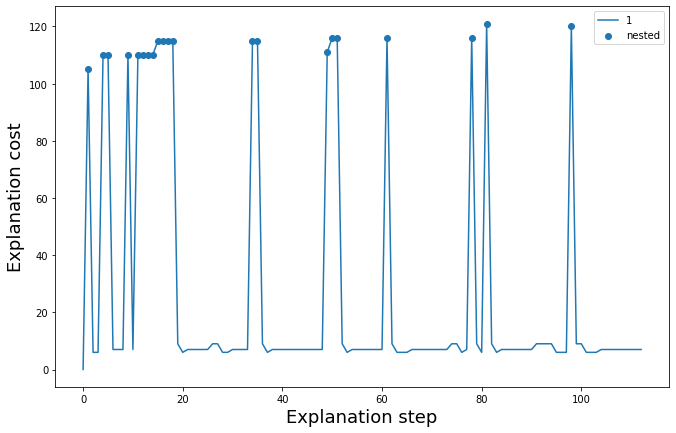

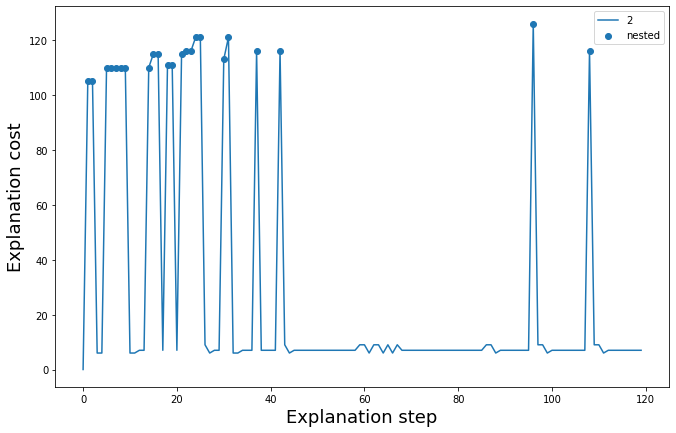

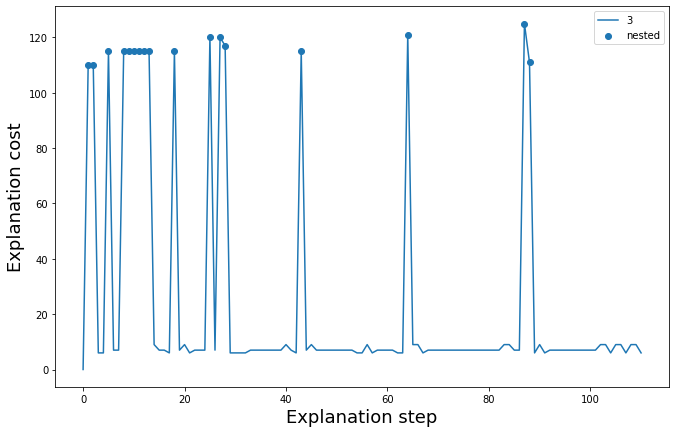

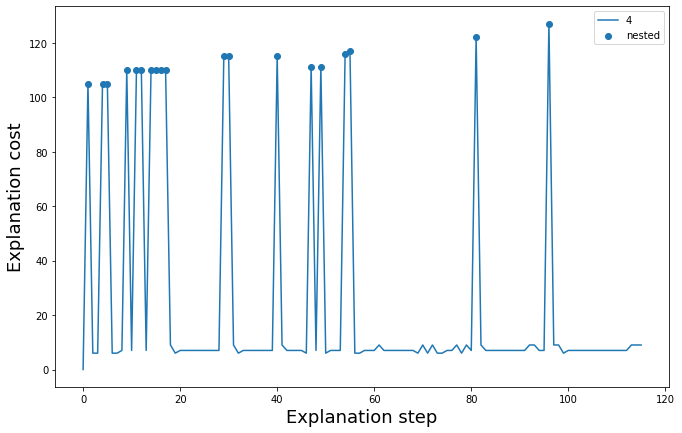

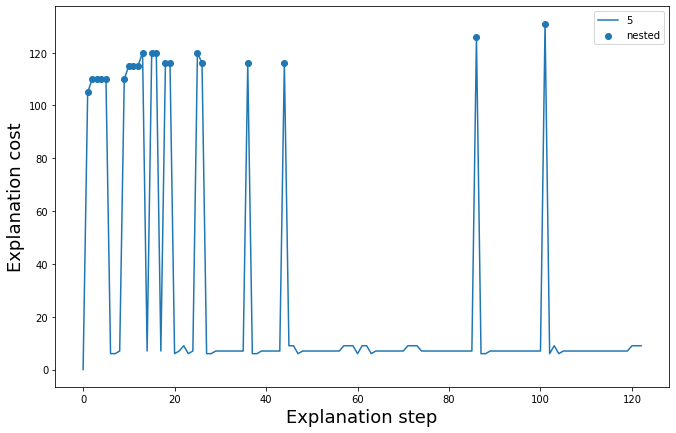

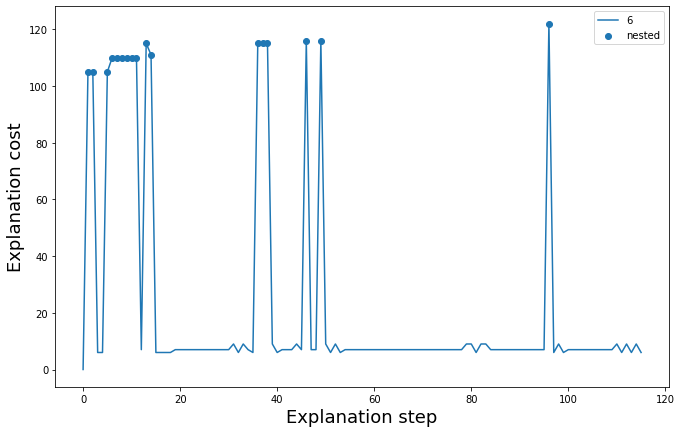

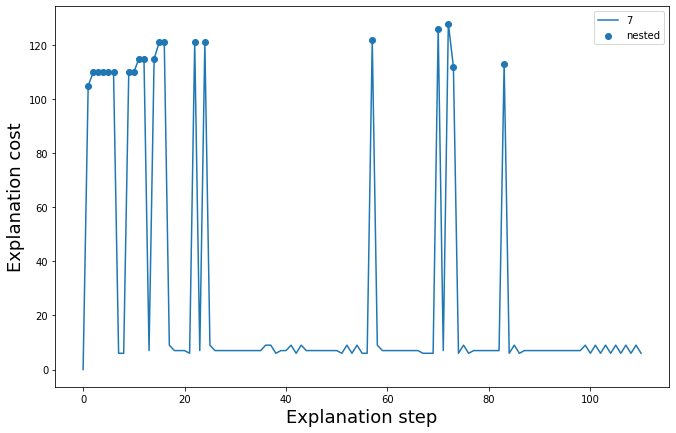

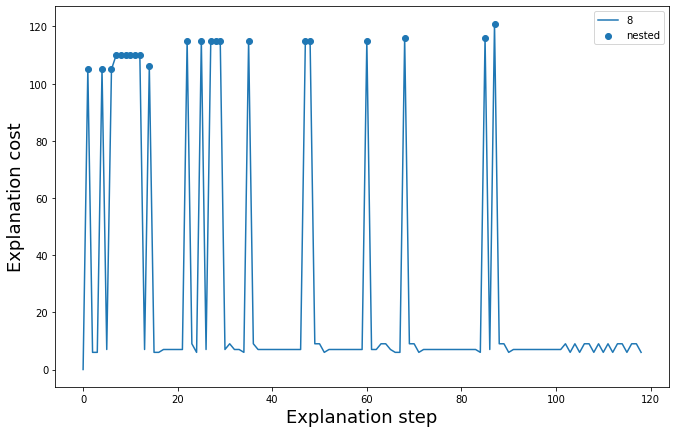

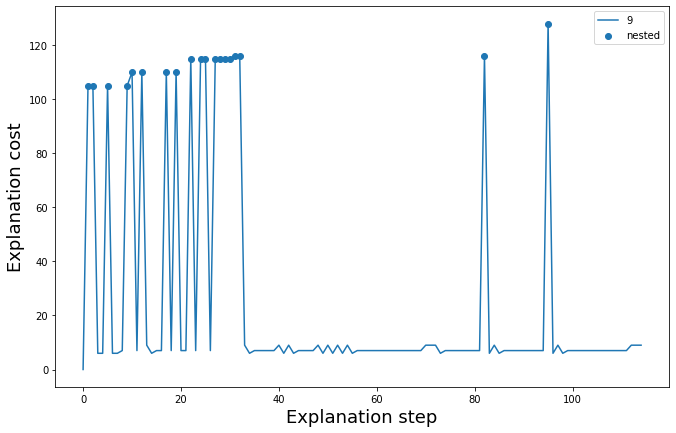

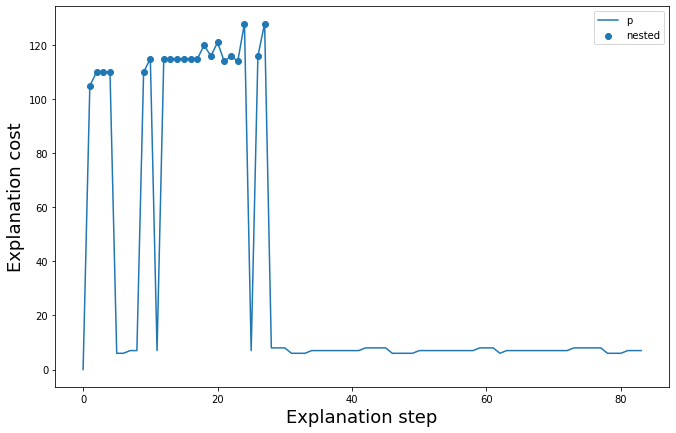

In [87]:
#p18 = matching_table['p18.output.json']
#plot_puzzle(puzzle_explanation_array, stats_puzzle, p18)
#p25 = matching_table['p25.output.json']
#plot_puzzle(puzzle_explanation_array, stats_puzzle, p25)

p1 = '1'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p1)
p2 = '2'#matching_table['p25.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, p2)
p3 = '3'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p3)
p4 = '4'#matching_table['p25.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, p4)
p5 = '5'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p5)
p6 = '6'#matching_table['p25.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, p6)
p7 = '7'
plot_puzzle(puzzle_explanation_array, stats_puzzle, p7)
p8 = '8'#matching_table['p25.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, p8)
p9 = '9'#matching_table['p25.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, p9)
pasta = matching_table['pasta.output.json']
plot_puzzle(puzzle_explanation_array, stats_puzzle, pasta)



In [89]:
dir_path = holygrail_dir_path + '/latex/journal/aij20/tables/'
df_table1.to_latex(dir_path + '07_experiments_table1.tex')
df_table2.to_latex(dir_path + '07_experiments_table2.tex')
df_table3.to_latex(dir_path + '07_experiments_table3.tex')

In [90]:
np.linspace(0, 10, 11)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

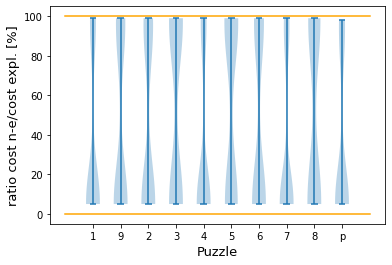

In [93]:
def violin_plot(ratios_puzzles):
    saveFile = True
    # Create a figure instance
    #fig = plt.figure()
    
    # Create an axes instance
    #ax = plt.add_axes([0, 0, 1, 1])
    plt.violinplot([ratios_puzzles[x] for x in ratios_puzzles])
    
    plt.plot(np.linspace(0, 11, 12), [100] + [100 for x in ratios_puzzles] + [100], color='orange')
    plt.plot(np.linspace(0, 11, 12), [0] + [0 for x in ratios_puzzles] + [0], color='orange')

    plt.xticks(np.linspace( 1, len([x.replace('.output.json','') for x in ratios_puzzles]),  len([x.replace('.output.json','') for x in ratios_puzzles])),[x.replace('.output.json','') for x in ratios_puzzles], rotation=0  )
    plt.ylabel('ratio cost n-e/cost expl. [%]', fontsize=13)
    plt.xlabel('Puzzle', fontsize=13)
    #plt.xlabels()
    # Create the boxplot
    
    
    if saveFile:
        dir_path = holygrail_dir_path + '/latex/journal/aij20/figures/'
        filename = 'violin_plot' '.pdf'
        filepath = dir_path + filename
        plt.savefig(filepath, bbox_inches='tight', format='pdf')

    plt.show()

    
violin_plot(ratios_puzzles)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

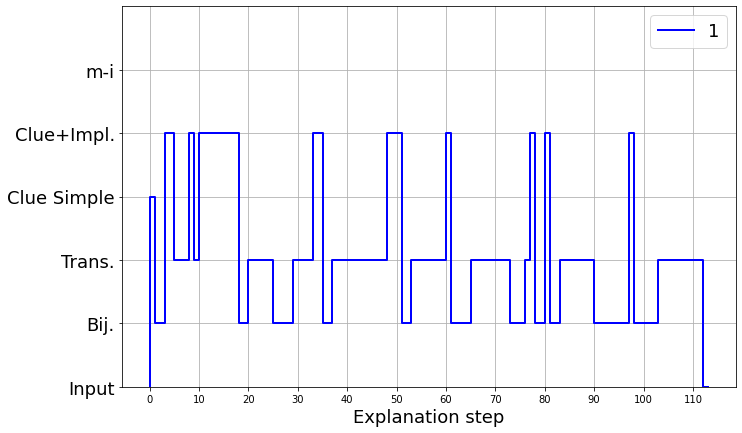

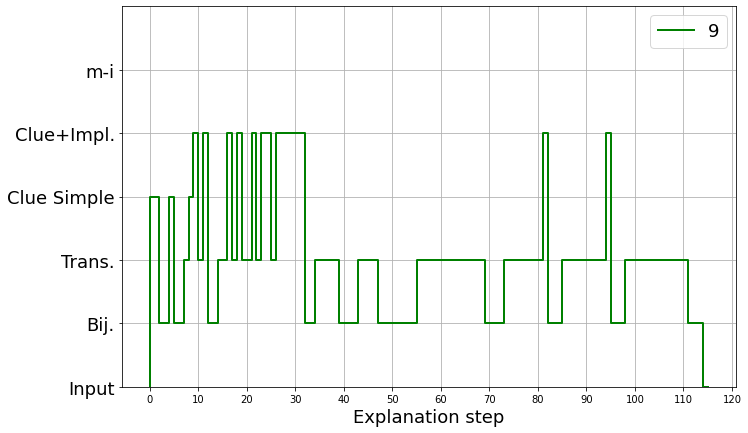

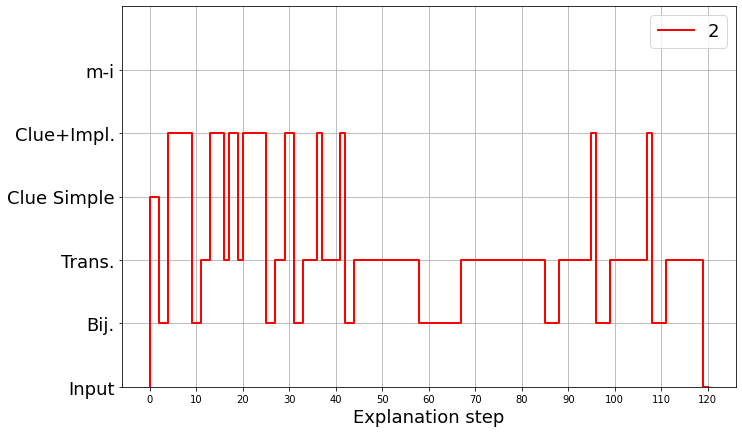

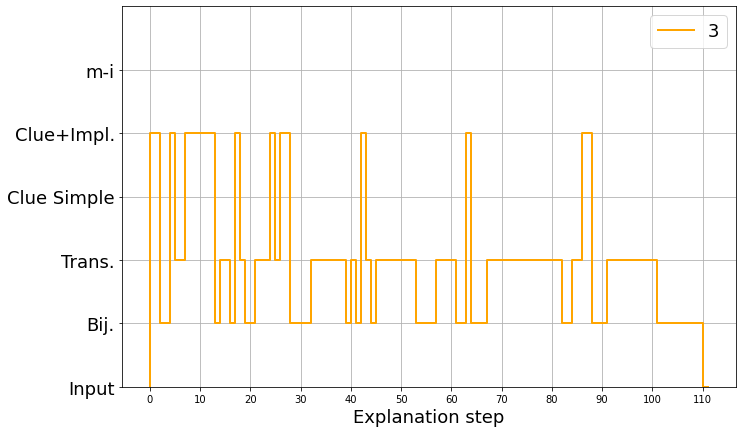

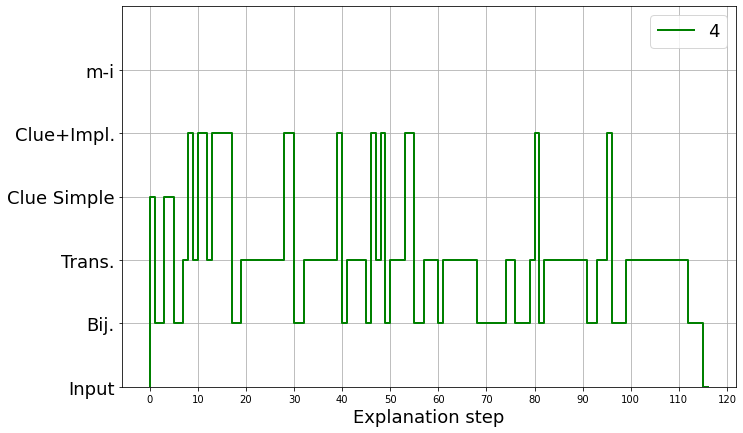

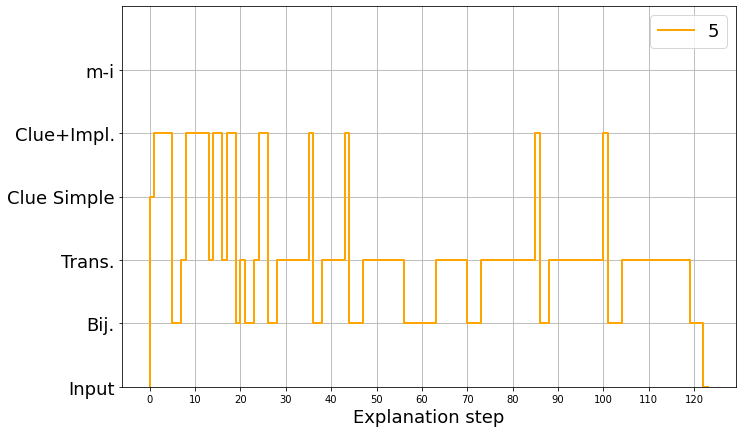

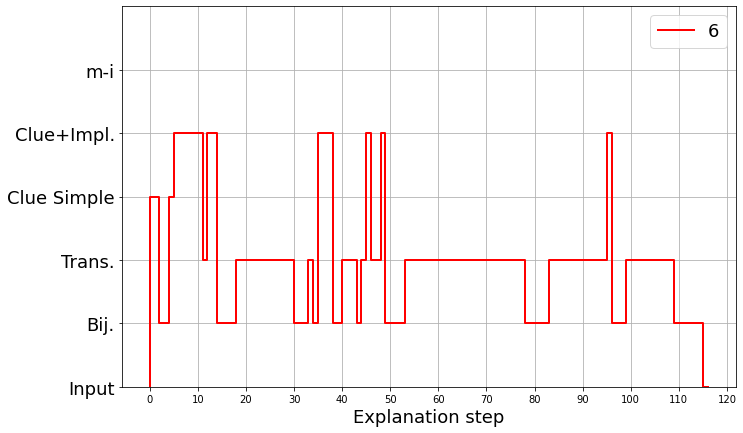

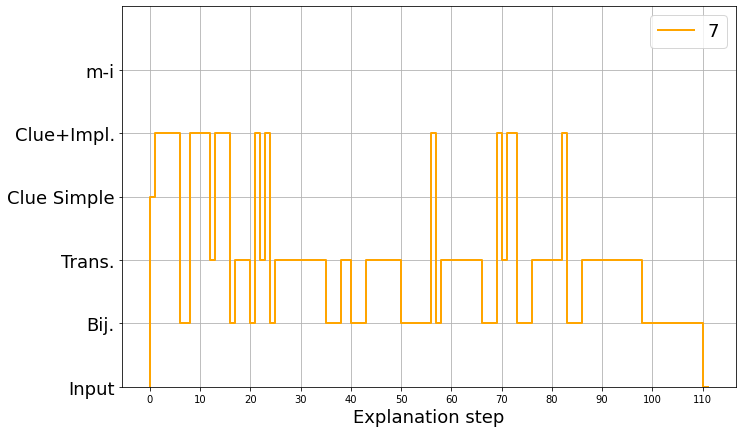

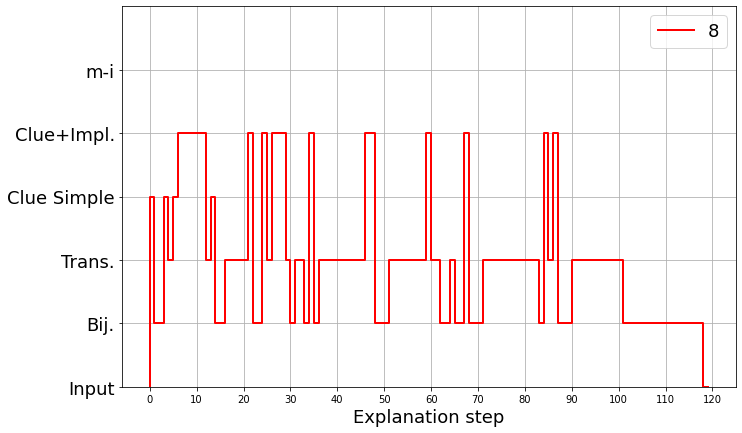

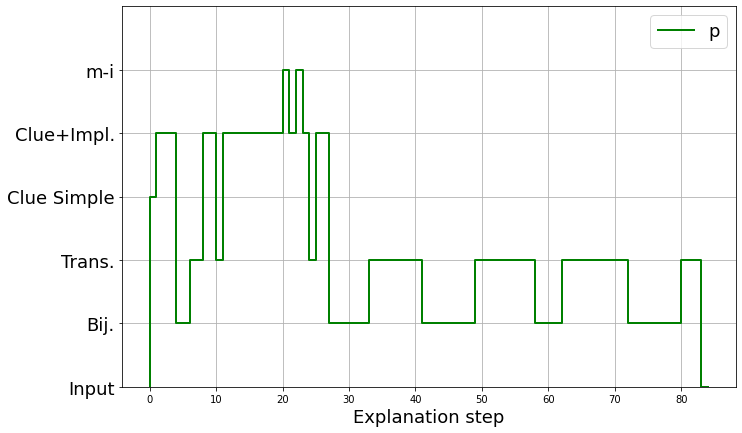

In [98]:
def match_clues(explanation_array):
    
    clues = []
    array_constraints = ['Bijectivity','Transitivity constraint','Combination of logigram constraints']
    clue_match = {
        'Bijectivity':1,
        'Transitivity constraint':2,
        'Combination of logigram constraints':5,
        'Solution!':0
    }
    for expl in explanation_array:
        if expl["clue"] in array_constraints:
            clues.append(clue_match[expl["clue"]])
        else:
            amount = amount_implicit_clues_expl(expl["cost"], len(expl["assumptions"]))
            if amount > 0:
                clues.append(4)            
            else:
                clues.append(3)
    return clues

def plot_costs(puzzle_explanation_array):

    idx = 0
    for i in puzzle_explanation_array:
        #if i not in ['p', '4','7']:
        #    continue
        colors = ["blue","green", "red", "orange", "green","orange", "red", "orange", "red","green", "red", "orange"]
        explanation_array = puzzle_explanation_array[i]
        clues = match_clues(explanation_array)
        
        fig, ax = plt.subplots()  
        ax.set_yticks(range(0, 6))
        ax.set_xticks([ x*10 for x in range(0, 13)])
        plt.ylim([0, 6])
            

        ax.set_yticklabels(['Input', 'Bij.', 'Trans.',  'Clue Simple', 'Clue+Impl.', 'm-i'],  fontsize=18)
    #print(data[i])
        locs, labels = plt.yticks()
        plt.setp(labels, rotation=0)

        plt.step([x for x in range(0, len(clues)+2)] ,[0] + clues + [0],  linewidth=2, markersize=12, color = colors[idx],label=str(i))
        idx +=1
        #fig.suptitle('Explanation cost vs step number')
        #plt.ylabel('Explanation type')
        plt.xlabel('Explanation step',  fontsize=18)
        plt.legend(loc='upper right',  fontsize=18)
        plt.grid(True)
        fig.set_size_inches(11, 7)
        dir_experiments = holygrail_dir_path + 'experiments/02_AIJ/figures/'
        dir_latex = holygrail_dir_path + 'latex/journal/aij20/figures/'
        filepath = dir_latex + "plot_cost_steps_" +str(i) + '.eps'
        plt.savefig(filepath, bbox_inches='tight', format='eps')
        
plot_costs(puzzle_explanation_array)

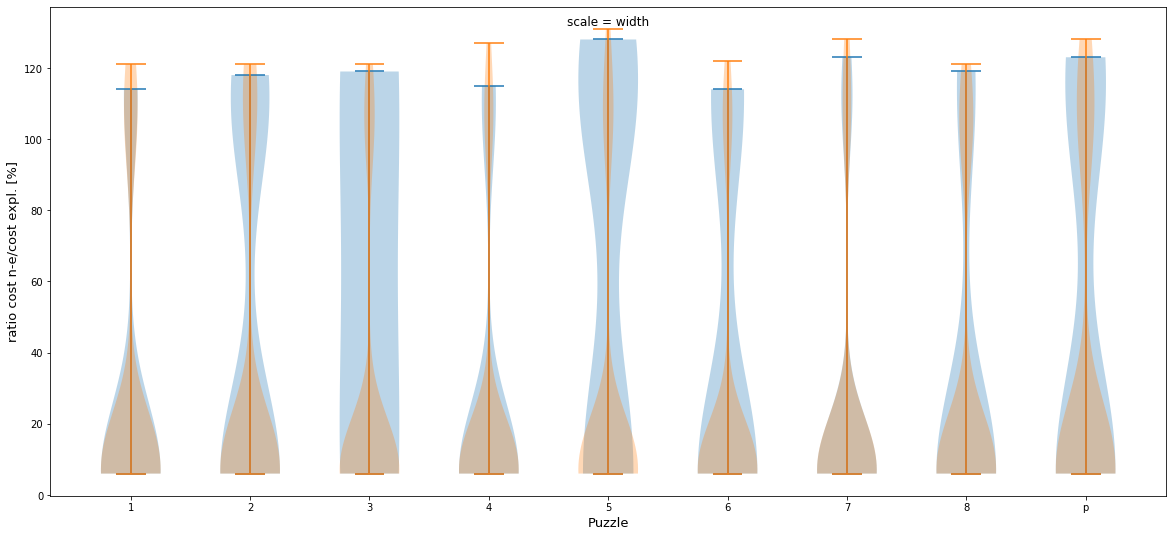

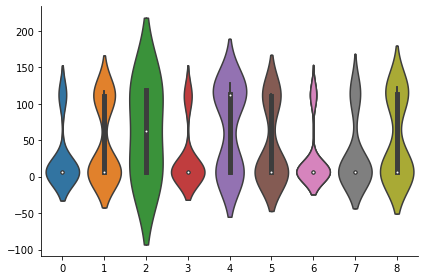

In [225]:
l_cost_nested = []
for p in nested_data:
    ltemp = []
    for expl in nested_data[p]:
        for seq in expl["nested_explanations"]:
            for r_expl in seq["reason_sequence"]:
                ltemp.append(r_expl["cost"])
    l_cost_nested.append(ltemp)
    
l_cost = []

for p in puzzle_explanation_array:
    l_cost.append([expl["cost"] for expl in puzzle_explanation_array[p]])
fig, ax = plt.subplots()  

plt.violinplot(l_cost_nested)
plt.violinplot(l_cost)
#plt.plot(np.linspace(0, 10, 11), [100] + [100 for x in ratios_puzzles] + [100], color='orange')
#plt.plot(np.linspace(0, 10, 11), [0] + [0 for x in ratios_puzzles] + [0], color='orange')

plt.xticks(np.linspace( 1, len([x.replace('.output.json','') for x in ratios_puzzles]),  len([x.replace('.output.json','') for x in ratios_puzzles])),[x.replace('.output.json','') for x in ratios_puzzles], rotation=0  )
plt.ylabel('ratio cost n-e/cost expl. [%]', fontsize=13)
plt.xlabel('Puzzle', fontsize=13)
fig.set_size_inches(20, 9)



import seaborn as sns
fig, axes_col = plt.subplots()
#print(axes)
#axes_cols = (axes.flatten()[::2], axes.flatten()[1::2])
#print(axes_col)
#for (sex_name, sex), axes_col in zip(tips.groupby('sex'), axes_cols):
#sns.countplot(x="day", hue="smoker", data=sex, ax=axes_col[0])
#    for scale, ax in zip(['area', 'count', 'width'], axes_col[1:]):
for scale in ['area', 'count', 'width']:
    sns.violinplot(data=l_cost_nested, split=True, scale=scale)
    ax.set_title('scale = {}'.format(scale), y=0.95)
sns.despine()
fig.tight_layout()

In [226]:
print((np.random.normal(0, 1, size=10000), np.random.normal(0, 2, size=10000)))

(array([ 0.45246141,  0.20039269,  0.39817625, ...,  2.49973874,
       -0.64354546,  0.46585731]), array([ 0.84644817, -3.65007656,  0.42043535, ...,  0.09351763,
        0.0496965 , -3.41583707]))


ValueError: List of violinplot statistics and `positions` values must have the same length

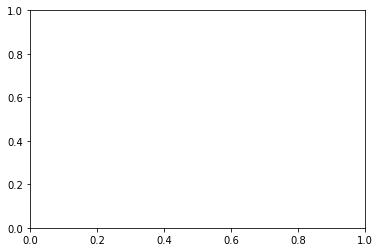

In [232]:
ltemp = []
for expl in nested_data['1']:
    for seq in expl["nested_explanations"]:
        for r_expl in seq["reason_sequence"]:
            ltemp.append(r_expl["cost"])
#l_cost_nested.append(ltemp)

fig, ax = plt.subplots()  

v1 = ax.violinplot(([expl["cost"] for expl in puzzle_explanation_array['1']], ltemp ), points=100, positions=np.arange(0, len(ltemp)), 
               showmeans=False, showextrema=False, showmedians=False)
#plt.violinplot(l_cost)
#plt.plot(np.linspace(0, 10, 11), [100] + [100 for x in ratios_puzzles] + [100], color='orange')
#plt.plot(np.linspace(0, 10, 11), [0] + [0 for x in ratios_puzzles] + [0], color='orange')

#plt.xticks(np.linspace( 1, len([x.replace('.output.json','') for x in ratios_puzzles]),  len([x.replace('.output.json','') for x in ratios_puzzles])),[x.replace('.output.json','') for x in ratios_puzzles], rotation=0  )
plt.ylabel('ratio cost n-e/cost expl. [%]', fontsize=13)
plt.xlabel('Puzzle', fontsize=13)
fig.set_size_inches(20, 9)


for b in v1['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('r')['a'][1]

v2 = ax.violinplot(([expl["cost"] for expl in puzzle_explanation_array['1']], ltemp ), points=100, positions=np.arange(0, len(ltemp)), 
               showmeans=False, showextrema=False, showmedians=False)

for b in v2['bodies']:
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('b')

ax.legend([v1['bodies'][0],v2['bodies'][0]],['data1', 'data2'])